**Requirements:**<br>
The goal is to input an artists name (or spotify link) and output songs and specific time locations in a song with a direction on how to interpret the samples that were given.

**Assumption:**<br>
The main assumption in this Project is that the audio files reside in Spotify and the following script uses heavily the audio analytics provided by Spotify Web API.

**Approach:**<br>
The following steps mainly outlines the approach taken to solve the problem :-

* Take the Artist's name as Input from User.
* Get all the Artist's tracks from Spotify.
* Invoke Spotify Audio analysis of all the tracks.
* Build a dataset consisting of all the 'parts of songs' for all the songs.
* Use the dataset to build an Unsupervised Model using KMeans Clustering algorithm to Cluster the Song segments.
* Build Nearest Neighbors Unsupervised learners from each Cluster obtained above.
* Get 5 Nearest Neighbor for each Song segment and recommend if the inter-point distance is less than the Mean distance.
* The number of recommendations per Cluster is capped at 5.


**Future Improvements:**<br>
* KMeans algorithm has been used here to build the Clusters. Other more complex algorithms like DBSCAN can be evaluated on the built dataset.
* All the features in 'segments' data from the Audio analysis are used here. More analysis can be performed to vet which features (if any) can be removed.
* This project recommends related sound segments from the artist's own albums. However, it can be extended to other artists based on similar genre.
* Other track features such as popularity of tracks can be used in the final recommendation - the rationale being some song segments can be used to mix with other segments to generate popular mixes.

In [1]:
! pip install spotipy

In [0]:
# Import the necessary libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

import spotipy
import spotipy.util as util
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [0]:
# Connect to Spotify's Web API and obtain Token
username = input('UserName: ')
client_id = input('Client_ID: ')
client_secret = input('Client_Secret: ')
redirect_uri = input('Redirect_URI: ')

try:
    token = util.prompt_for_user_token(username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
except:
    os.remove(f'.cache-{username}')
    token = util.prompt_for_user_token(username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)

# Can be any Artist's name
name = 'Eminem'
spotify = spotipy.Spotify(auth=token)


In [8]:
%%time
# Obtain the data for all the songs of the Artist
results = spotify.search(q='artist:' + name, type='album')
print(results)

albums = dict()
tracks = dict()

for album in results['albums']['items']:
    albums[album['name']] = album['uri']

for album in albums:
    album_tracks = spotify.album_tracks(albums[album])
    for track in album_tracks['items']:
        tracks[track['name']] = track['uri']
        
# 'tracks' contain the mapping of the Tracks and URI
print(tracks)

{'albums': {'href': 'https://api.spotify.com/v1/search?query=artist%3AEminem&type=album&market=IN&offset=0&limit=10', 'items': [{'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/7dGJo4pcD2V6oG8kP0tJRR'}, 'href': 'https://api.spotify.com/v1/artists/7dGJo4pcD2V6oG8kP0tJRR', 'id': '7dGJo4pcD2V6oG8kP0tJRR', 'name': 'Eminem', 'type': 'artist', 'uri': 'spotify:artist:7dGJo4pcD2V6oG8kP0tJRR'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/3H

In [10]:
%%time
# 'data' contains the features of all the tracks
data = []
for i in tqdm(range(0, len(tracks), 10)):
    feats = spotify.audio_features(list(tracks.values())[i:i+10])
    for feat in feats:
        data.append(list(feat.values()))
    
data = pd.DataFrame(data, columns=feats[0].keys())

100%|██████████| 15/15 [00:00<00:00, 17.15it/s]

CPU times: user 138 ms, sys: 13.3 ms, total: 151 ms
Wall time: 880 ms


In [11]:
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.939,0.551,1,-9.126,1,0.291,0.0311,0.0,0.1920,0.420,118.552,audio_features,2jt2WxXMCD4zjACthkJQVE,spotify:track:2jt2WxXMCD4zjACthkJQVE,https://api.spotify.com/v1/tracks/2jt2WxXMCD4z...,https://api.spotify.com/v1/audio-analysis/2jt2...,337941,4
1,0.809,0.737,1,-5.186,1,0.108,0.0441,0.0,0.3410,0.367,80.025,audio_features,2XTquzYQAdT1Hk78bOUwsv,spotify:track:2XTquzYQAdT1Hk78bOUwsv,https://api.spotify.com/v1/tracks/2XTquzYQAdT1...,https://api.spotify.com/v1/audio-analysis/2XTq...,226938,4
2,0.876,0.786,10,-4.884,0,0.306,0.0627,0.0,0.1270,0.575,153.068,audio_features,60SdxE8apGAxMiRrpbmLY0,spotify:track:60SdxE8apGAxMiRrpbmLY0,https://api.spotify.com/v1/tracks/60SdxE8apGAx...,https://api.spotify.com/v1/audio-analysis/60Sd...,244679,4
3,0.742,0.414,9,-18.755,0,0.923,0.9640,0.0,0.7990,0.430,129.943,audio_features,3xnIYtj7GS6WTXshdsb1uG,spotify:track:3xnIYtj7GS6WTXshdsb1uG,https://api.spotify.com/v1/tracks/3xnIYtj7GS6W...,https://api.spotify.com/v1/audio-analysis/3xnI...,19400,4
4,0.907,0.640,6,-6.542,1,0.354,0.2610,0.0,0.0785,0.803,120.995,audio_features,0evt4UZbdhnHtcAnxkm6A1,spotify:track:0evt4UZbdhnHtcAnxkm6A1,https://api.spotify.com/v1/tracks/0evt4UZbdhnH...,https://api.spotify.com/v1/audio-analysis/0evt...,222477,4


In [12]:
%%time
# The following script creates a Data Frame containing the details of Audio Analysis
# 'song_segments' contains the song segments for all the songs
# 'song_seg_mapping' contains a mapping between the segment data and the track URI
song_segments = []
seg_cols = []

song_seg_mapping = dict()

for uri in tqdm(data['uri'].values):
    results = spotify.audio_analysis(uri)
    for segment in results['segments'][:-1]:
        temp = []
        for item in segment:
            if item == 'pitches' or item == 'timbre':
                temp.extend(segment[item])
            else:
                temp.append(segment[item])
            
        song_seg_mapping[repr(temp)] = uri
        song_segments.append(temp)
    
for key, val in segment.items():
    if key == 'pitches' or key == 'timbre':
        for i in range(len(val)):
            seg_cols.append(f'{key}_{i}')
    else:
        seg_cols.append(key)
        
song_segments = pd.DataFrame(song_segments, columns=seg_cols)

100%|██████████| 150/150 [03:49<00:00,  1.56s/it]


CPU times: user 8.45 s, sys: 495 ms, total: 8.95 s
Wall time: 3min 50s


In [13]:
song_segments.head()

,start,duration,confidence,loudness_start,loudness_max_time,loudness_max,pitches_0,pitches_1,pitches_2,pitches_3,...,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11
0,0.00000,0.42381,0.000,-60.000,0.00000,-60.000,0.990,1.000,0.939,0.902,...,9.469,-28.480,57.491,-50.067,14.833,5.359,-27.228,0.973,-10.640,-7.228
1,0.42381,0.22562,1.000,-60.000,0.13138,-34.193,0.077,0.081,0.048,0.065,...,2.230,-159.138,62.141,43.177,12.687,-27.250,-30.284,65.368,22.124,11.704
2,0.64943,0.21469,0.811,-34.564,0.11381,-23.376,0.043,0.043,0.044,0.354,...,26.244,-84.155,28.806,-10.594,21.190,-12.487,-0.730,8.488,9.580,19.860
3,0.86413,0.12236,0.603,-24.417,0.09370,-17.118,0.271,0.268,0.312,1.000,...,86.926,-37.941,54.903,-26.264,21.987,-0.808,-1.083,7.043,13.005,-5.033
4,0.98649,0.40222,0.566,-17.517,0.10173,-10.527,0.118,0.544,1.000,0.165,...,87.602,-12.943,58.008,-18.193,2.994,12.991,-9.918,-10.447,-3.125,19.967


Starting Cluster #2
Starting Cluster #4
Starting Cluster #7
Starting Cluster #15
Starting Cluster #18
Starting Cluster #25
Starting Cluster #35


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


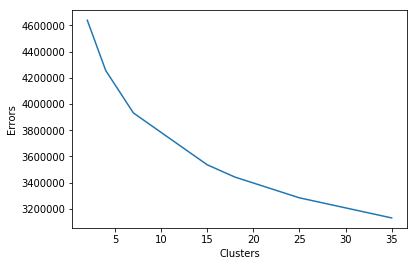

CPU times: user 1.2 s, sys: 473 ms, total: 1.67 s
Wall time: 4min 21s


In [14]:
%%time
# 'scaled_segments' contains the scaled data of the song segments
sc = StandardScaler()
scaled_segments = sc.fit_transform(song_segments)

# Build KMeans Clustering with various Cluster sizes and decide the Cluster size using the Elbow method
errors = []; clusters = [2, 4, 7, 15, 18, 25, 35];
for i in clusters:
    print(f'Starting Cluster #{i}')
    model = KMeans(n_clusters=i, random_state=42, verbose=0, n_jobs=-1)
    model.fit(scaled_segments)
    errors.append(model.inertia_)

plt.plot(clusters, errors)
plt.xlabel('Clusters')
plt.ylabel('Errors')
plt.show()

In [15]:
%%time
# Build the final Model based on the optimal cluster size obtained above and build the Clusters
model = KMeans(n_clusters=7, random_state=42, verbose=0, n_jobs=-1)
model.fit(scaled_segments)

cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}

CPU times: user 152 ms, sys: 26.4 ms, total: 178 ms
Wall time: 17.8 s


In [16]:
for i in cluster_sets:
    print(f'Cluster# {i} Size ===> {len(cluster_sets[i])}')

Cluster# 0 Size ===> 20109
Cluster# 1 Size ===> 39881
Cluster# 2 Size ===> 9031
Cluster# 3 Size ===> 27098
Cluster# 4 Size ===> 21347
Cluster# 5 Size ===> 25106
Cluster# 6 Size ===> 25253


In [19]:
%%time
# 'cluster_segs' contains all the clustered segments per cluster (0-6)
cluster_segs = defaultdict(list)
clust_num = 0

for c in cluster_sets:
    for i in cluster_sets[c]:
        cluster_segs[clust_num].append(scaled_segments[i])
    clust_num += 1

CPU times: user 85.9 ms, sys: 4.09 ms, total: 90 ms
Wall time: 92.8 ms


In [0]:
def run_recomm(distances, indices, recomms=5):
    '''
    This Function generates the Recommendations for each Cluster.
    '''
    print(f'Mean Distance: {np.mean(distances)}, Median Distance: {np.median(distances)}\n')
    mean_dist = np.mean(distances)

    def show_recomm(arr):
        '''
        This Function displays the identified recommendations.
        '''
        print(f'Indices: {arr}')
        for i in arr:
            try:
                start_time = song_segments.iloc[i]['start']
                end_time = start_time + song_segments.iloc[i]['duration']
                uri = song_seg_mapping[repr(list(song_segments.iloc[i].values))]
                print(f'{uri} {round(start_time, 2)}-{round(end_time, 2)}')
            except KeyError as err:
                print(f'Key Not Found for Index: {i}')
        print("\n")
    
    # 'count' keeps a track of the Max recommendations per Cluster
    count = 1
    for dist, indx in zip(distances, indices):
        
        if count > recomms:
            break
        
        flag = False
        temp = []
        for i in range(1, len(dist)):
            # IF the distance between the data-points is less the mean distance for the Cluster then it is marked for recommendation
            if dist[i] <= mean_dist:
                if not flag:
                    flag = True
                    temp.append(indx[0])
                temp.append(indx[i])
        if len(temp) > 0:
            print(f'Recommendation# {count}:')
            show_recomm(temp)
            count += 1

In [21]:
%%time
# Run the Recommendation engine for all the Clusters capping at 5 per cluster.
for i in cluster_segs:
    print(f'Cluster# {i+1}\n----------\n')
    
    nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
    nbrs = nn.fit(cluster_segs[i])
    distances, indices = nbrs.kneighbors(cluster_segs[i])
    
    run_recomm(distances, indices)

Cluster# 1
----------

Mean Distance: 2.358310768220872, Median Distance: 2.7798418226807478

Recommendation# 1:
Indices: [11, 1354]
spotify:track:2jt2WxXMCD4zjACthkJQVE 4.73-5.04
spotify:track:2jt2WxXMCD4zjACthkJQVE 270.49-270.78


Recommendation# 2:
Indices: [12, 28]
spotify:track:2jt2WxXMCD4zjACthkJQVE 5.04-5.27
spotify:track:2jt2WxXMCD4zjACthkJQVE 9.08-9.32


Recommendation# 3:
Indices: [15, 17]
spotify:track:2jt2WxXMCD4zjACthkJQVE 6.25-6.54
spotify:track:2jt2WxXMCD4zjACthkJQVE 6.78-7.06


Recommendation# 4:
Indices: [17, 15]
spotify:track:2jt2WxXMCD4zjACthkJQVE 6.78-7.06
spotify:track:2jt2WxXMCD4zjACthkJQVE 6.25-6.54


Recommendation# 5:
Indices: [28, 12]
spotify:track:2jt2WxXMCD4zjACthkJQVE 9.08-9.32
spotify:track:2jt2WxXMCD4zjACthkJQVE 5.04-5.27


Cluster# 2
----------

Mean Distance: 2.0157924033337253, Median Distance: 2.382529736914118

Recommendation# 1:
Indices: [29, 21148]
spotify:track:2jt2WxXMCD4zjACthkJQVE 9.32-9.58
spotify:track:7io19rjxOFu3pGuZgBI6Pk 29.45-29.75


Rec